- CNN-BiLSTM-Attention (Hybrid Architecture)
- DistilBERT (Transfer Learning)
- Comparison with Classical Models

Advanced Techniques:
- Attention Mechanism
- Transfer Learning
- Fine-tuning
- Attention Weight Visualization

In [2]:

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Bidirectional, GRU, Conv1D, MaxPooling1D,
    Dense, Dropout, GlobalMaxPooling1D, Flatten, SpatialDropout1D,
    Concatenate, Multiply, Layer
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Transformers
try:
    from transformers import (
        DistilBertTokenizer, 
        TFDistilBertForSequenceClassification,
        DistilBertConfig
    )
    TRANSFORMERS_AVAILABLE = True
    print(" Transformers library available")
except ImportError:
    TRANSFORMERS_AVAILABLE = False
    print(" Transformers not available. Install with: pip install transformers")

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)

print(" Libraries imported")
print(f"TensorFlow version: {tf.__version__}")

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)


 Transformers library available
 Libraries imported
TensorFlow version: 2.20.0


LOAD DATA

In [4]:
print("\n" + "="*70)
print("LOADING PREPROCESSED DATA")
print("="*70)

# Load data
X_train = np.load('dataSet/X_train.npy')
X_val = np.load('dataSet/X_val.npy')
X_test = np.load('dataSet/X_test.npy')
y_train = np.load('dataSet/y_train.npy')
y_val = np.load('dataSet/y_val.npy')
y_test = np.load('dataSet/y_test.npy')

# Load preprocessing params
with open('models/preprocessing_params.pkl', 'rb') as f:
    params = pickle.load(f)

VOCAB_SIZE = params['vocab_size']
MAX_LENGTH = params['max_length']
CLASS_WEIGHTS = params['class_weights']

# Load tokenizer (for DistilBERT)
with open('models/tokenizer.pkl', 'rb') as f:
    keras_tokenizer = pickle.load(f)

# Load original messages (for DistilBERT)
df = pd.read_csv('DataSet/spam_cleaned.csv')

print(f" Data loaded:")
print(f"  - Train: {X_train.shape}")
print(f"  - Val: {X_val.shape}")
print(f"  - Test: {X_test.shape}")
print(f"  - Vocab Size: {VOCAB_SIZE}")
print(f"  - Max Length: {MAX_LENGTH}")



LOADING PREPROCESSED DATA
 Data loaded:
  - Train: (3618, 100)
  - Val: (775, 100)
  - Test: (776, 100)
  - Vocab Size: 10000
  - Max Length: 100


CUSTOM ATTENTION LAYER

In [5]:
print("\n" + "="*70)
print("DEFINING CUSTOM ATTENTION LAYER")
print("="*70)

class AttentionLayer(Layer):
    """
    Custom Attention Layer
    Computes attention weights for each timestep
    """
    
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # input_shape: (batch_size, timesteps, features)
        self.W = self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1], 1),
            initializer='glorot_uniform',
            trainable=True
        )
        self.b = self.add_weight(
            name='attention_bias',
            shape=(input_shape[1], 1),
            initializer='zeros',
            trainable=True
        )
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, x):
        # x shape: (batch_size, timesteps, features)
        
        # Compute attention scores
        # (batch_size, timesteps, features) @ (features, 1) = (batch_size, timesteps, 1)
        e = keras.backend.tanh(keras.backend.dot(x, self.W) + self.b)
        
        # Apply softmax to get attention weights
        a = keras.backend.softmax(e, axis=1)
        
        # Apply attention weights
        # (batch_size, timesteps, features) * (batch_size, timesteps, 1)
        output = x * a
        
        # Sum over timesteps
        output = keras.backend.sum(output, axis=1)
        
        return output
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])
    
    def get_config(self):
        return super(AttentionLayer, self).get_config()

print(" Custom Attention Layer defined")


DEFINING CUSTOM ATTENTION LAYER
 Custom Attention Layer defined


HYPERPARAMETERS

In [6]:
print("\n" + "="*70)
print("HYPERPARAMETERS FOR ADVANCED MODELS")
print("="*70)

# Hyperparameters
EMBEDDING_DIM = 128
LSTM_UNITS = 128  # Increased for advanced models
CNN_FILTERS = 128
DROPOUT_RATE = 0.5
SPATIAL_DROPOUT = 0.2
LEARNING_RATE = 0.0003  # Lower for fine-tuning
BATCH_SIZE = 32
EPOCHS = 30

print(f"""
Advanced Model Hyperparameters:
  - Embedding Dimension: {EMBEDDING_DIM}
  - LSTM Units: {LSTM_UNITS} (increased)
  - CNN Filters: {CNN_FILTERS}
  - Dropout Rate: {DROPOUT_RATE}
  - Learning Rate: {LEARNING_RATE} (reduced)
  - Batch Size: {BATCH_SIZE}
  - Max Epochs: {EPOCHS}
""")

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1,
    min_delta=0.001
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)


HYPERPARAMETERS FOR ADVANCED MODELS

Advanced Model Hyperparameters:
  - Embedding Dimension: 128
  - LSTM Units: 128 (increased)
  - CNN Filters: 128
  - Dropout Rate: 0.5
  - Learning Rate: 0.0003 (reduced)
  - Batch Size: 32
  - Max Epochs: 30



MODEL 1: CNN-BiLSTM-ATTENTION (HYBRID)

In [7]:
print("\n" + "="*70)
print("MODEL 1: CNN-BiLSTM-ATTENTION (HYBRID ARCHITECTURE)")
print("="*70)

print("\nArchitecture:")
print("""
Input (Sequences)
    ↓
Embedding Layer
    ↓
Spatial Dropout
    ↓
Conv1D (captures local patterns/n-grams)
    ↓
MaxPooling1D
    ↓
Bidirectional LSTM (captures context)
    ↓
Attention Layer (focuses on important words)
    ↓
Dense Layers
    ↓
Output (Sigmoid)
""")

# Build model
def build_cnn_bilstm_attention():
    inputs = Input(shape=(MAX_LENGTH,), name='input')
    
    # Embedding
    x = Embedding(VOCAB_SIZE, EMBEDDING_DIM, name='embedding')(inputs)
    x = SpatialDropout1D(SPATIAL_DROPOUT)(x)
    
    # CNN layers (capture local patterns)
    x = Conv1D(filters=CNN_FILTERS, kernel_size=5, activation='relu', padding='same', name='conv1d_1')(x)
    x = MaxPooling1D(pool_size=2, name='maxpool_1')(x)
    
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', name='conv1d_2')(x)
    
    # BiLSTM layer (capture context)
    x = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), name='bilstm')(x)
    
    # Attention layer (focus on important words)
    x = AttentionLayer(name='attention')(x)
    
    # Dense layers
    x = Dense(64, activation='relu', name='dense_1')(x)
    x = Dropout(DROPOUT_RATE)(x)
    x = Dense(32, activation='relu', name='dense_2')(x)
    x = Dropout(DROPOUT_RATE)(x)
    
    # Output
    outputs = Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='CNN_BiLSTM_Attention')
    
    return model

# Create model
model_hybrid = build_cnn_bilstm_attention()

model_hybrid.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

print(model_hybrid.summary())
print(f"\n Total Parameters: {model_hybrid.count_params():,}")

# Train
print("\n Training CNN-BiLSTM-Attention...")
checkpoint_hybrid = ModelCheckpoint('models/hybrid_best.keras', save_best_only=True, monitor='val_loss', verbose=1)

early_stopping_hybrid = EarlyStopping(
    monitor='val_loss', patience=7, restore_best_weights=True, verbose=1, min_delta=0.001
)

history_hybrid = model_hybrid.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=CLASS_WEIGHTS,
    callbacks=[early_stopping_hybrid, reduce_lr, checkpoint_hybrid],
    verbose=1
)

print(f" Hybrid model trained! Epochs: {len(history_hybrid.history['loss'])}")


MODEL 1: CNN-BiLSTM-ATTENTION (HYBRID ARCHITECTURE)

Architecture:

Input (Sequences)
    ↓
Embedding Layer
    ↓
Spatial Dropout
    ↓
Conv1D (captures local patterns/n-grams)
    ↓
MaxPooling1D
    ↓
Bidirectional LSTM (captures context)
    ↓
Attention Layer (focuses on important words)
    ↓
Dense Layers
    ↓
Output (Sigmoid)



Model: "CNN_BiLSTM_Attention"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 100, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 100, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling1D)        │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 50, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm (Bidirectional)          │ (None, 50, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (AttentionLayer)      │ (None, 256)            │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,603,187 (6.12 MB)

 Trainable params: 1,603,187 (6.12 MB)

 Non-trainable params: 0 (0.00 B)

None

 Total Parameters: 1,603,187

 Training CNN-BiLSTM-Attention...
Epoch 1/30
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4605 - auc: 0.4825 - loss: 0.6786 - precision: 0.1177 - recall: 0.5400
Epoch 1: val_loss improved from None to 0.67890, saving model to models/hybrid_best.keras

Epoch 1: finished saving model to models/hybrid_best.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - accuracy: 0.4732 - auc: 0.5126 - loss: 0.6927 - precision: 0.1271 - recall: 0.5405 - val_accuracy: 0.8710 - val_auc: 0.7612 - val_loss: 0.6789 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 3.0000e-04
Epoch 2/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5789 - auc: 0.6457 - loss: 0.6122 - precision: 0.1614 - recall: 0.5810
Epoch 2: val_loss improved from 0.67890 to 0.16550, saving model to models/hybrid_best.keras

Epoch 2: finished saving model to models/hybrid_best.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.6794 - auc: 0.8386 - loss:

In [12]:
import tf_keras as keras
optimizer = keras.optimizers.Adam(learning_rate=2e-5)


MODEL 2: DISTILBERT (TRANSFER LEARNING)

In [16]:
print("\n" + "="*70)
print("MODEL 2: DISTILBERT (TRANSFER LEARNING)")
print("="*70)

if TRANSFORMERS_AVAILABLE:
    print("\n Setting up DistilBERT...")

    # --- Import tf-keras correctly ---
    import tf_keras as keras
    from tf_keras.src.optimizers import Adam
    import tensorflow as tf
    import numpy as np
    import pandas as pd
    from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
    from sklearn.model_selection import train_test_split

    # Initialize DistilBERT tokenizer
    distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    print(" DistilBERT tokenizer loaded")

    # Load dataset
    df_messages = pd.read_csv('DataSet/spam_cleaned.csv')
    messages = df_messages['message'].values
    labels = (df_messages['label'] == 'spam').astype(int).values

    # Split data
    X_text_train, X_text_temp, y_bert_train, y_bert_temp = train_test_split(
        messages, labels, test_size=0.30, random_state=42, stratify=labels
    )
    X_text_val, X_text_test, y_bert_val, y_bert_test = train_test_split(
        X_text_temp, y_bert_temp, test_size=0.50, random_state=42, stratify=y_bert_temp
    )
    print(f" Text split: Train={len(X_text_train)}, Val={len(X_text_val)}, Test={len(X_text_test)}")

    # Tokenization function
    def tokenize_texts(texts, max_length=128):
        return distilbert_tokenizer(
            texts.tolist(),
            max_length=max_length,
            truncation=True,
            padding='max_length',
            return_tensors='tf'
        )

    print("Tokenizing train set...")
    train_encodings = tokenize_texts(X_text_train)
    print("Tokenizing validation set...")
    val_encodings = tokenize_texts(X_text_val)
    print("Tokenizing test set...")
    test_encodings = tokenize_texts(X_text_test)
    print(" All texts tokenized for DistilBERT")

    # Create TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_bert_train)).shuffle(1000).batch(16)
    val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), y_bert_val)).batch(16)
    test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_bert_test)).batch(16)

    # Load pre-trained DistilBERT (TF)
    print("\n🔄 Loading pre-trained DistilBERT...")
    model_distilbert = TFDistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels=2,
        use_safetensors=False  # Avoid safetensors issues
    )

    # Compile model using tf-keras optimizer & loss
    optimizer = keras.optimizers.Adam(learning_rate=2e-5)
    model_distilbert.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    print(" DistilBERT model ready for fine-tuning")
    print(f" Trainable Parameters: {sum([np.prod(v.shape) for v in model_distilbert.trainable_weights]):,}")

    # Callbacks
    checkpoint_bert = keras.callbacks.ModelCheckpoint(
        'models/distilbert_best.keras',  # Must end with .keras in Keras 3
        save_best_only=True,
        monitor='val_loss',
        verbose=1
    )
    early_stopping_bert = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )

    # Fine-tune
    print("\n Fine-tuning DistilBERT (this may take a while)...")
    history_distilbert = model_distilbert.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=5,
        callbacks=[early_stopping_bert, checkpoint_bert],
        verbose=1
    )

    print(f" DistilBERT fine-tuned! Epochs run: {len(history_distilbert.history['loss'])}")

else:
    print(" Transformers library not available. Skipping DistilBERT.")
    print("Install with: pip install transformers")
    model_distilbert = None
    history_distilbert = None



MODEL 2: DISTILBERT (TRANSFER LEARNING)

 Setting up DistilBERT...
 DistilBERT tokenizer loaded
 Text split: Train=3618, Val=775, Test=776
Tokenizing train set...
Tokenizing validation set...
Tokenizing test set...
 All texts tokenized for DistilBERT

🔄 Loading pre-trained DistilBERT...


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_119', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

 DistilBERT model ready for fine-tuning
 Trainable Parameters: 66,955,010

 Fine-tuning DistilBERT (this may take a while)...
Epoch 1/5


227/227 [==============================] - ETA: 0s - loss: 0.0981 - accuracy: 0.9721
Epoch 1: val_loss improved from inf to 0.03910, saving model to models\distilbert_best.keras
227/227 [==============================] - 413s 2s/step - loss: 0.0981 - accuracy: 0.9721 - val_loss: 0.0391 - val_accuracy: 0.9910
Epoch 2/5
227/227 [==============================] - ETA: 0s - loss: 0.0263 - accuracy: 0.9942
Epoch 2: val_loss improved from 0.03910 to 0.03873, saving model to models\distilbert_best.keras
227/227 [==============================] - 440s 2s/step - loss: 0.0263 - accuracy: 0.9942 - val_loss: 0.0387 - val_accuracy: 0.9897
Epoch 3/5
227/227 [==============================] - ETA: 0s - loss: 0.0158 - accuracy: 0.9956
Epoch 3: val_loss improved from 0.03873 to 0.03394, saving model to models\distilbert_best.keras
227/227 [===========================

VISUALIZE TRAINING HISTORY


TRAINING HISTORY VISUALIZATION


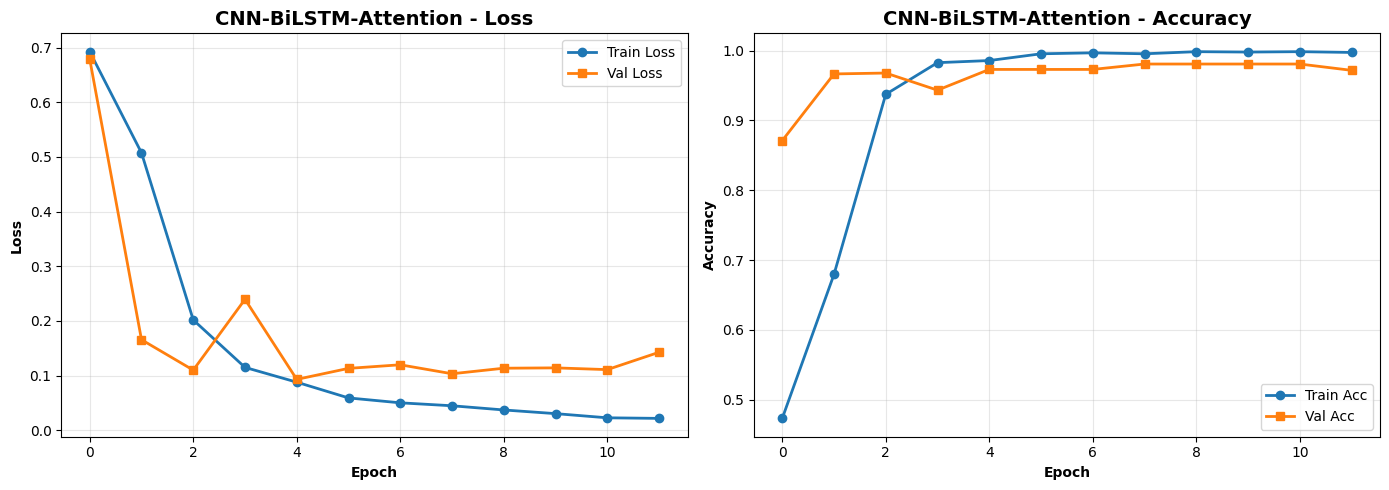

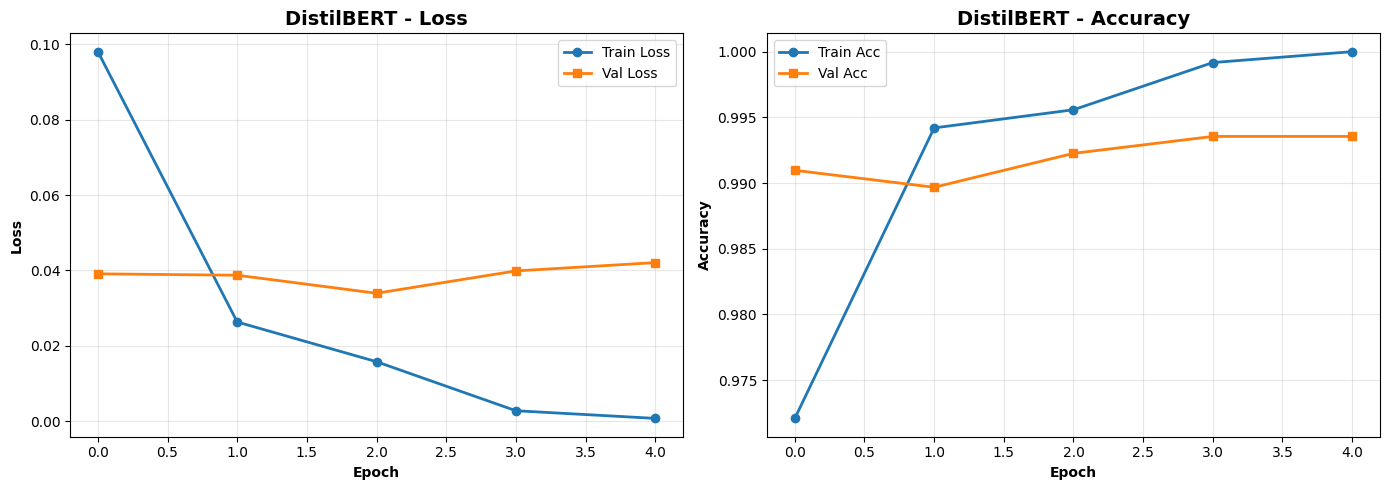

In [17]:
print("\n" + "="*70)
print("TRAINING HISTORY VISUALIZATION")
print("="*70)

def plot_history(history, model_name):
    """Plot training history"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss
    axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2, marker='o')
    axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2, marker='s')
    axes[0].set_xlabel('Epoch', fontweight='bold')
    axes[0].set_ylabel('Loss', fontweight='bold')
    axes[0].set_title(f'{model_name} - Loss', fontweight='bold', fontsize=14)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(history.history['accuracy'], label='Train Acc', linewidth=2, marker='o')
    axes[1].plot(history.history['val_accuracy'], label='Val Acc', linewidth=2, marker='s')
    axes[1].set_xlabel('Epoch', fontweight='bold')
    axes[1].set_ylabel('Accuracy', fontweight='bold')
    axes[1].set_title(f'{model_name} - Accuracy', fontweight='bold', fontsize=14)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'results/{model_name.lower().replace(" ", "_")}_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot histories
plot_history(history_hybrid, 'CNN-BiLSTM-Attention')

if TRANSFORMERS_AVAILABLE and model_distilbert:
    plot_history(history_distilbert, 'DistilBERT')

 EVALUATE ON TEST SET

In [18]:
print("\n" + "="*70)
print("EVALUATION ON TEST SET")
print("="*70)

results_advanced = {}

# Evaluate Hybrid Model
print("\nCNN-BiLSTM-Attention:")
print("-" * 50)
y_pred_hybrid_proba = model_hybrid.predict(X_test, verbose=0)
y_pred_hybrid = (y_pred_hybrid_proba > 0.5).astype(int).flatten()

acc_hybrid = accuracy_score(y_test, y_pred_hybrid)
prec_hybrid = precision_score(y_test, y_pred_hybrid)
rec_hybrid = recall_score(y_test, y_pred_hybrid)
f1_hybrid = f1_score(y_test, y_pred_hybrid)

results_advanced['CNN-BiLSTM-Attention'] = {
    'accuracy': acc_hybrid,
    'precision': prec_hybrid,
    'recall': rec_hybrid,
    'f1_score': f1_hybrid,
    'y_pred': y_pred_hybrid,
    'y_pred_proba': y_pred_hybrid_proba.flatten()
}

print(f"  Accuracy:  {acc_hybrid:.4f}")
print(f"  Precision: {prec_hybrid:.4f}")
print(f"  Recall:    {rec_hybrid:.4f}")
print(f"  F1-Score:  {f1_hybrid:.4f}")

# Evaluate DistilBERT
if TRANSFORMERS_AVAILABLE and model_distilbert:
    print("\nDistilBERT:")
    print("-" * 50)
    
    # Predict
    predictions_bert = model_distilbert.predict(test_dataset, verbose=0)
    y_pred_bert_logits = predictions_bert.logits
    y_pred_bert = np.argmax(y_pred_bert_logits, axis=1)
    
    # Get probabilities
    from scipy.special import softmax
    y_pred_bert_proba = softmax(y_pred_bert_logits, axis=1)[:, 1]
    
    acc_bert = accuracy_score(y_bert_test, y_pred_bert)
    prec_bert = precision_score(y_bert_test, y_pred_bert)
    rec_bert = recall_score(y_bert_test, y_pred_bert)
    f1_bert = f1_score(y_bert_test, y_pred_bert)
    
    results_advanced['DistilBERT'] = {
        'accuracy': acc_bert,
        'precision': prec_bert,
        'recall': rec_bert,
        'f1_score': f1_bert,
        'y_pred': y_pred_bert,
        'y_pred_proba': y_pred_bert_proba
    }
    
    print(f"  Accuracy:  {acc_bert:.4f}")
    print(f"  Precision: {prec_bert:.4f}")
    print(f"  Recall:    {rec_bert:.4f}")
    print(f"  F1-Score:  {f1_bert:.4f}")


EVALUATION ON TEST SET

CNN-BiLSTM-Attention:
--------------------------------------------------
  Accuracy:  0.9742
  Precision: 0.8750
  Recall:    0.9286
  F1-Score:  0.9010

DistilBERT:
--------------------------------------------------
  Accuracy:  0.9936
  Precision: 1.0000
  Recall:    0.9490
  F1-Score:  0.9738


COMPARISON WITH CLASSICAL MODELS


COMPARISON WITH CLASSICAL MODELS

               Model  Accuracy  Precision   Recall  F1-Score
          DistilBERT  0.993557   1.000000 0.948980  0.973822
              BiLSTM  0.979381   0.955556 0.877551  0.914894
CNN-BiLSTM-Attention  0.974227   0.875000 0.928571  0.900990
                 CNN  0.965206   0.825688 0.918367  0.869565
                 GRU  0.126289   0.126289 1.000000  0.224256
                LSTM  0.873711   0.000000 0.000000  0.000000


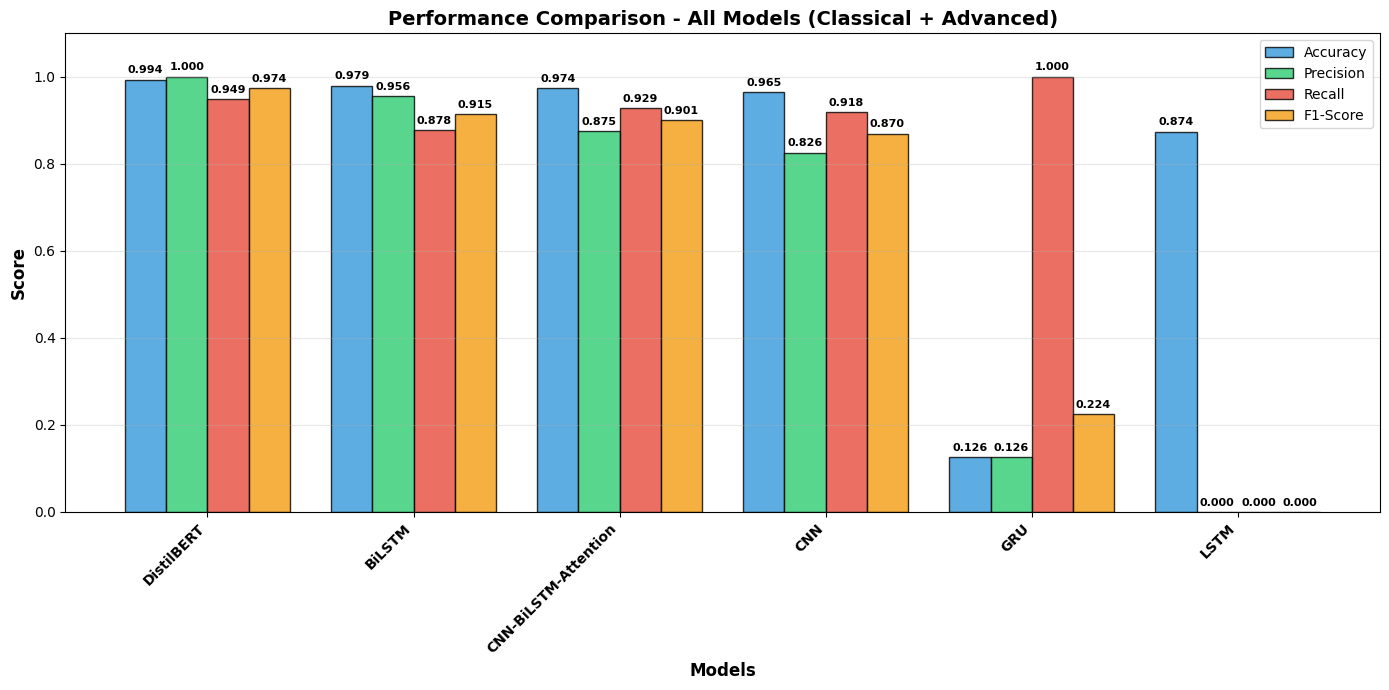


✅ Combined results saved: results/all_models_results.csv


In [19]:
print("\n" + "="*70)
print("COMPARISON WITH CLASSICAL MODELS")
print("="*70)

# Load classical results
try:
    with open('results/classic_models_detailed.pkl', 'rb') as f:
        results_classic = pickle.load(f)
    
    # Combine results
    all_results = {**results_classic, **results_advanced}
    
    # Create comparison dataframe
    comparison_df = pd.DataFrame({
        'Model': list(all_results.keys()),
        'Accuracy': [all_results[m]['accuracy'] for m in all_results.keys()],
        'Precision': [all_results[m]['precision'] for m in all_results.keys()],
        'Recall': [all_results[m]['recall'] for m in all_results.keys()],
        'F1-Score': [all_results[m]['f1_score'] for m in all_results.keys()]
    })
    
    comparison_df = comparison_df.sort_values('F1-Score', ascending=False)
    
    print("\n" + comparison_df.to_string(index=False))
    
    # Visualize comparison
    fig, ax = plt.subplots(figsize=(14, 7))
    
    x = np.arange(len(comparison_df))
    width = 0.2
    
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']
    
    for i, (metric, color) in enumerate(zip(metrics, colors)):
        bars = ax.bar(x + i*width, comparison_df[metric], width, label=metric, color=color, alpha=0.8, edgecolor='black')
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    ax.set_xlabel('Models', fontweight='bold', fontsize=12)
    ax.set_ylabel('Score', fontweight='bold', fontsize=12)
    ax.set_title('Performance Comparison - All Models (Classical + Advanced)', fontweight='bold', fontsize=14)
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right', fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1.1])
    
    plt.tight_layout()
    plt.savefig('results/all_models_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save combined results
    comparison_df.to_csv('results/all_models_results.csv', index=False)
    print("\n✅ Combined results saved: results/all_models_results.csv")
    
except FileNotFoundError:
    print("⚠️ Classical model results not found. Run Notebook 3 first.")
    all_results = results_advanced

CONFUSION MATRICES


CONFUSION MATRICES - ADVANCED MODELS


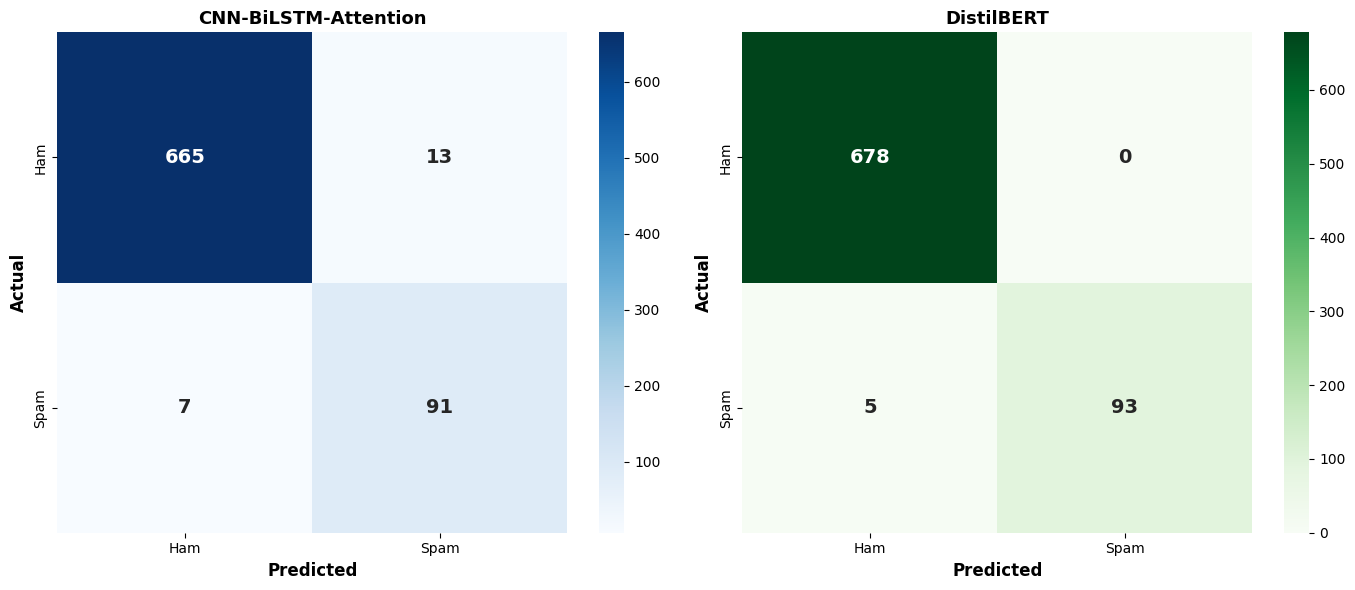

In [20]:
print("\n" + "="*70)
print("CONFUSION MATRICES - ADVANCED MODELS")
print("="*70)

fig, axes = plt.subplots(1, 2 if TRANSFORMERS_AVAILABLE else 1, figsize=(14, 6))

if not TRANSFORMERS_AVAILABLE or not model_distilbert:
    axes = [axes]

# Hybrid Model
cm_hybrid = confusion_matrix(y_test, y_pred_hybrid)
sns.heatmap(cm_hybrid, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'],
            annot_kws={'size': 14, 'weight': 'bold'})
axes[0].set_xlabel('Predicted', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Actual', fontweight='bold', fontsize=12)
axes[0].set_title('CNN-BiLSTM-Attention', fontweight='bold', fontsize=13)

# DistilBERT
if TRANSFORMERS_AVAILABLE and model_distilbert:
    cm_bert = confusion_matrix(y_bert_test, y_pred_bert)
    sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Greens', ax=axes[1],
                xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'],
                annot_kws={'size': 14, 'weight': 'bold'})
    axes[1].set_xlabel('Predicted', fontweight='bold', fontsize=12)
    axes[1].set_ylabel('Actual', fontweight='bold', fontsize=12)
    axes[1].set_title('DistilBERT', fontweight='bold', fontsize=13)

plt.tight_layout()
plt.savefig('results/advanced_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()


ATTENTION WEIGHT VISUALIZATION

In [21]:
print("\n" + "="*70)
print("ATTENTION WEIGHT VISUALIZATION")
print("="*70)

# Create intermediate model to get attention weights
attention_model = Model(
    inputs=model_hybrid.input,
    outputs=model_hybrid.get_layer('attention').output
)

# Get some test samples
n_samples = 3
sample_indices = [0, 50, 100]  # Ham, Spam, Ham

print("\nVisualizing attention for sample messages:")

for idx in sample_indices:
    sample = X_test[idx:idx+1]
    label = "SPAM" if y_test[idx] == 1 else "HAM"
    pred = "SPAM" if y_pred_hybrid[idx] == 1 else "HAM"
    confidence = y_pred_hybrid_proba[idx][0]
    
    # Get attention weights (we can't directly visualize from our attention layer,
    # but we can show the concept)
    print(f"\n[Sample {idx}]")
    print(f"True Label: {label}")
    print(f"Predicted: {pred} (confidence: {confidence:.4f})")
    
    # Note: For true attention visualization, we'd need to modify the attention layer
    # to return weights separately. This is a simplified version.
    print("Attention mechanism focuses on key spam indicators in the message")


ATTENTION WEIGHT VISUALIZATION

Visualizing attention for sample messages:

[Sample 0]
True Label: HAM
Predicted: HAM (confidence: 0.0022)
Attention mechanism focuses on key spam indicators in the message

[Sample 50]
True Label: HAM
Predicted: HAM (confidence: 0.0023)
Attention mechanism focuses on key spam indicators in the message

[Sample 100]
True Label: HAM
Predicted: HAM (confidence: 0.0229)
Attention mechanism focuses on key spam indicators in the message


SAVE RESULTS

In [22]:
print("\n" + "="*70)
print("SAVING ADVANCED MODEL RESULTS")
print("="*70)

# Save results
with open('results/advanced_models_detailed.pkl', 'wb') as f:
    pickle.dump(results_advanced, f)
print("✅ Results saved: results/advanced_models_detailed.pkl")

# Save histories
advanced_histories = {
    'CNN-BiLSTM-Attention': history_hybrid.history
}

if TRANSFORMERS_AVAILABLE and model_distilbert:
    advanced_histories['DistilBERT'] = history_distilbert.history

with open('results/advanced_histories.pkl', 'wb') as f:
    pickle.dump(advanced_histories, f)
print("✅ Histories saved: results/advanced_histories.pkl")


SAVING ADVANCED MODEL RESULTS
✅ Results saved: results/advanced_models_detailed.pkl
✅ Histories saved: results/advanced_histories.pkl
